Провести сравнение RNN, LSTM, GRU на датасете отзывов (из предыдущих занятий/материалов)

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

import warnings 
warnings.filterwarnings("ignore", category=Warning)

## 0. Загрузка и обзор данных

In [ ]:
data = pd.read_excel("отзывы за лето.xls")
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [ ]:
data['Rating'].value_counts()

5    14586
1     2276
4     2138
3      911
2      748
Name: Rating, dtype: int64

In [ ]:
data = data[data['Rating'] != 3]
data['target'] = data['Rating'] > 3
data['target'] = data['target'].astype(int)

## 1. Обработка текстов

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

from pymorphy2 import MorphAnalyzer

Ограничимся минимальной очисткой текстов - только от точек, запятых и предлогов:

In [ ]:
punctuation = r'[,.]'
morpher = MorphAnalyzer()

stop = {'без', 'безо', 'близ', 'в', 'во', 'вместо', 'вне',
        'для', 'до', 'за', 'из', 'изо', 'из-за', 'из-под', 
        'к', 'ко', 'кроме', 'между', 'меж', 'на', 'над', 'надо',
        'о', 'об', 'обо', 'от', 'ото', 'перед', 'передо', 'пред', 'предо',
        'пo', 'под', 'подо', 'при', 'про', 'ради', 'с', 'со',
        'сквозь', 'среди', 'у', 'через', 'чрез'}

Функции для обработки текстов:

In [ ]:
def normalize_text(text_list):
    return [morpher.parse(word)[0].normal_form \
            for word in text_list if word not in stop]

def preprocess_text(text):    
    text_list = nltk.word_tokenize(str(text))
    text_list = normalize_text(text_list)
    return text_list

Обработка текстов:

In [ ]:
data['Text'] = data['Content'].str.lower()
data['Text'] = data['Text'].str.replace(r'[.,]', ' ')
data['Text'] = [preprocess_text(text_list) for text_list in tqdm(data['Text'])]

100%|██████████| 19748/19748 [00:30<00:00, 653.85it/s]


Датафрейм с обработанными текстами:

In [ ]:
data['Text'] = data['Text'].str.join(' ')
data.head(n=10)

,Rating,Content,Date,target,Text
0,5,It just works!,2017-08-14,1,it just works !
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,1,целое удобноной приложение минус хотеть слишко...
2,5,Отлично все,2017-08-14,1,отлично весь
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,1,стать зависать 1 % работа антивирус далёкий ни...
4,5,"Очень удобно, работает быстро.",2017-08-14,1,очень удобно работать быстро
5,5,Всё удобно норм 👍👍👍,2017-08-14,1,весь удобно норма 👍👍👍
6,5,Очень удобное приложение.,2017-08-14,1,очень удобный приложение
7,5,Все устраивает,2017-08-14,1,весь устраивать
8,5,У меня работает все четко. В отличии от банком...,2017-08-14,1,я работать весь чётко отличие банкомат который...
9,5,Очень все хорошо👍,2017-08-14,1,очень весь хорошо👍


Разделение выборки на обучающую и тестовую:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = data['Text']
y = data['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

Преобразование выборок для подачи сети на вход:

In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Embedding, SimpleRNN, LSTM, GRU, Masking
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
train_corpus = X_train.values
test_corpus = X_test.values

In [ ]:
tokenizer = Tokenizer(num_words=None, 
                      filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                      lower = False, split = ' ')
tokenizer.fit_on_texts(train_corpus)

sequences_train = tokenizer.texts_to_sequences(train_corpus)
sequences_test = tokenizer.texts_to_sequences(test_corpus)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in train_corpus])

X_train_sequanced = pad_sequences(sequences_train, maxlen=training_length)
X_test_sequanced = pad_sequences(sequences_test, maxlen=training_length)

## 2. Обучение RNN

Сеть из вебинара:

In [ ]:
model1 = Sequential()
model1.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model1.add(Masking(mask_value=0.0))
model1.add(SimpleRNN(64))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

Обучение сети:

In [ ]:
history1 = model1.fit(X_train_sequanced, y_train,
                      batch_size=10,
                      epochs=10,
                      verbose=1,
                      validation_split=0.1)

Epoch 1/10
1333/1333 [==============================] - 63s 47ms/step - loss: 0.2345 - accuracy: 0.9045 - val_loss: 0.2095 - val_accuracy: 0.9096
Epoch 2/10
1333/1333 [==============================] - 63s 47ms/step - loss: 0.1554 - accuracy: 0.9401 - val_loss: 0.2076 - val_accuracy: 0.9157
Epoch 3/10
1333/1333 [==============================] - 63s 47ms/step - loss: 0.1374 - accuracy: 0.9458 - val_loss: 0.2362 - val_accuracy: 0.9116
Epoch 4/10
1333/1333 [==============================] - 63s 47ms/step - loss: 0.1151 - accuracy: 0.9572 - val_loss: 0.2238 - val_accuracy: 0.9049
Epoch 5/10
1333/1333 [==============================] - 63s 47ms/step - loss: 0.0965 - accuracy: 0.9667 - val_loss: 0.2590 - val_accuracy: 0.9130
Epoch 6/10
1333/1333 [==============================] - 63s 47ms/step - loss: 0.0866 - accuracy: 0.9692 - val_loss: 0.2931 - val_accuracy: 0.9123
Epoch 7/10
1333/1333 [==============================] - 63s 47ms/step - loss: 0.0709 - accuracy: 0.9769 - val_loss: 0.2591 -

Проверка сети на тестовой выборке:

In [ ]:
loss, acc = model1.evaluate(X_test_sequanced, y_test, batch_size=10, verbose=1)

494/494 [==============================] - 5s 10ms/step - loss: 0.3305 - accuracy: 0.8773


## 3. Обучение LSTM

Сеть из вебинара:

In [ ]:
model2 = Sequential()
model2.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model2.add(Masking(mask_value=0.0))
model2.add(LSTM(64, recurrent_dropout=0.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

Обучение сети:

In [ ]:
history2 = model2.fit(X_train_sequanced, y_train,
                      batch_size=10,
                      epochs=10,
                      verbose=1,
                      validation_split=0.1)

Epoch 1/10
1333/1333 [==============================] - 223s 167ms/step - loss: 0.2157 - accuracy: 0.9098 - val_loss: 0.2286 - val_accuracy: 0.9069
Epoch 2/10
1333/1333 [==============================] - 223s 167ms/step - loss: 0.1351 - accuracy: 0.9473 - val_loss: 0.2176 - val_accuracy: 0.9184
Epoch 3/10
1333/1333 [==============================] - 222s 167ms/step - loss: 0.1000 - accuracy: 0.9635 - val_loss: 0.2210 - val_accuracy: 0.9231
Epoch 4/10
1333/1333 [==============================] - 222s 167ms/step - loss: 0.0781 - accuracy: 0.9746 - val_loss: 0.2391 - val_accuracy: 0.9143
Epoch 5/10
1333/1333 [==============================] - 224s 168ms/step - loss: 0.0611 - accuracy: 0.9783 - val_loss: 0.3429 - val_accuracy: 0.9089
Epoch 6/10
1333/1333 [==============================] - 223s 167ms/step - loss: 0.0511 - accuracy: 0.9822 - val_loss: 0.3342 - val_accuracy: 0.9116
Epoch 7/10
1333/1333 [==============================] - 223s 167ms/step - loss: 0.0419 - accuracy: 0.9856 - val_

Проверка сети на тестовой выборке:

In [ ]:
loss, acc = model2.evaluate(X_test_sequanced, y_test, batch_size=10, verbose=1)

494/494 [==============================] - 11s 22ms/step - loss: 0.4574 - accuracy: 0.9139


## 4. Обучение GRU

Сеть из вебинара:

In [ ]:
model3 = Sequential()
model3.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model3.add(Masking(mask_value=0.0))
model3.add(GRU(64, recurrent_dropout=0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

Обучение сети:

In [ ]:
history3 = model3.fit(X_train_sequanced, y_train,
                      batch_size=10,
                      epochs=10,
                      verbose=1,
                      validation_split=0.1)

Epoch 1/10
1333/1333 [==============================] - 195s 147ms/step - loss: 0.2183 - accuracy: 0.9109 - val_loss: 0.2250 - val_accuracy: 0.9190
Epoch 2/10
1333/1333 [==============================] - 194s 145ms/step - loss: 0.1254 - accuracy: 0.9523 - val_loss: 0.2142 - val_accuracy: 0.9285
Epoch 3/10
1333/1333 [==============================] - 195s 146ms/step - loss: 0.0863 - accuracy: 0.9666 - val_loss: 0.2332 - val_accuracy: 0.9130
Epoch 4/10
1333/1333 [==============================] - 195s 147ms/step - loss: 0.0666 - accuracy: 0.9776 - val_loss: 0.2238 - val_accuracy: 0.9217
Epoch 5/10
1333/1333 [==============================] - 196s 147ms/step - loss: 0.0512 - accuracy: 0.9818 - val_loss: 0.2935 - val_accuracy: 0.9197
Epoch 6/10
1333/1333 [==============================] - 196s 147ms/step - loss: 0.0389 - accuracy: 0.9863 - val_loss: 0.3405 - val_accuracy: 0.9204
Epoch 7/10
1333/1333 [==============================] - 196s 147ms/step - loss: 0.0323 - accuracy: 0.9887 - val_

Проверка сети на тестовой выборке:

In [ ]:
loss, acc = model3.evaluate(X_test_sequanced, y_test, batch_size=10, verbose=1)

494/494 [==============================] - 10s 21ms/step - loss: 0.4707 - accuracy: 0.9161


## 5. Выводы

Построим графики долей правильных ответов на валидации в процессе обучения RNN, LSTM, GRU:

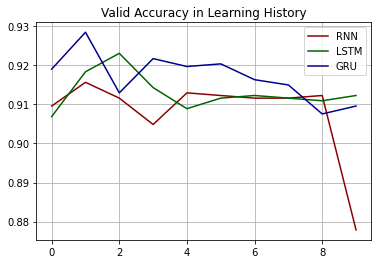

In [ ]:
plt.plot(history1.history['val_accuracy'], label='RNN', c='darkred')
plt.plot(history2.history['val_accuracy'], label='LSTM', c='darkgreen')
plt.plot(history3.history['val_accuracy'], label='GRU', c='darkblue')
plt.title('Valid Accuracy in Learning History')
plt.legend(loc='best')
plt.grid(True)
plt.show()

**Выводы:**
 - LSTM, GRU дают примерно одинаковое качество (доля правильных ответов в диапазоне от 0.91 до 0.92), RNN немного хуже;
 - RNN обучилась быстрее (63 секунды на эпоху), GRU (195 секунд на эпоху), LSTM (223 секунды на эпоху) - намного медленее.

## Дополнительное задание

Написать на numpy LSTM-ячейку и проверить её работу с весами. полученными из обученной keras-модели LSTM.

Получение весов из keras-модели:

In [ ]:
# весовые матрицы и векторы сдвигов
Ws, Us, bs = model2.layers[2].get_weights()

# размерность вектора скрытого состояния
H = 64

Вырежем из сети LSTM первые слои
 - до LSTM-слоя (слои 0, 1);
 - с LSTM-слоем (слои 0, 1, 2);

и оформим их в keras-модели - первая для получения входных векторов для написанной на numpy LSTM-ячейки (embs_layer), вторая для её валидации (lstm_layer):

In [ ]:
embs_layer = Model(inputs=model2.input,
                   outputs=model2.layers[1].output,
                   name='embs_layer')

lstm_layer = Model(inputs=model2.input,
                   outputs=model2.layers[2].output,
                   name='lstm_layer')

Получение входных векторов (embs) из первого тестового сообщения для LSTM-ячейки: 

In [ ]:
inp = X_test_sequanced[0].reshape(1, -1)

embs = embs_layer(inp).numpy()

**LSTM-ячейка написана на основе примеров ([link1](https://en.wikipedia.org/wiki/Long_short-term_memory#LSTM_with_a_forget_gate), [link2](https://fairyonice.github.io/Extract-weights-from-Keras's-LSTM-and-calcualte-hidden-and-cell-states.html)):**

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def tanh(x):
    return np.tanh(x)


def lstm(x, h_tm1, c_tm1):
    s_t = x_t @ Ws + h_tm1 @ Us + bs
    
    i  = sigmoid(s_t[:H])      # входной вентиль (input gate)
    f  = sigmoid(s_t[1*H:2*H]) # вентиль забывания (forget gate)
    _c = tanh(s_t[2*H:3*H])    # вектор-кандидат состояния памяти
    o  = sigmoid(s_t[3*H:])    # выходной вентиль (output gate)
    c_t = i * _c + f * c_tm1   # текущий вектор состояния памяти
    h_t = o * tanh(c_t)        # текущий вектор скрытого состояния
    
    return h_t, c_t

Инициализируем векторы состояния памяти и скрытого состояния, после чего в цикле перебираем входные векторы, подавая их в LSTM-ячейку с учетом предыдущих векторов состояния памяти и скрытого состояния.
<br>Выходом ячейки считаем последний вектор скрытого состояния:

In [ ]:
h_tm1 = np.zeros(H)
c_tm1 = np.zeros(H)
for x_t in tqdm(embs[0]):
    h_t, c_t = lstm(x_t, h_tm1, c_tm1)
    h_tm1, c_tm1 = h_t, c_t

100%|██████████| 155/155 [00:00<00:00, 5884.64it/s]


Выход написанной на numpy LSTM-ячейки:

In [ ]:
lstm_custom_out = h_t.reshape(1, H)
print(lstm_custom_out)

[[ 5.85987040e-01  1.00802415e-02  2.70556841e-02  4.13827999e-01
  -3.84269373e-02  3.08639195e-02  9.70589248e-02  2.22769122e-03
   7.65729655e-03 -5.80939142e-04  7.96204363e-02  4.00368015e-03
  -4.68257436e-02 -1.67085760e-02 -2.39128293e-02 -1.11640982e-01
  -5.33592985e-02 -1.89299428e-02  3.83360435e-02 -5.64420683e-01
   1.06727492e-02 -2.06889269e-02 -3.25906837e-02  1.78115142e-02
   5.40638624e-01  3.18057469e-02 -8.06994719e-02  2.99003326e-02
  -3.95796290e-01 -6.86902733e-01  9.09084948e-03 -1.70819146e-03
  -3.00373857e-02 -2.23652728e-02  4.44513098e-02  2.39409571e-02
  -2.38041992e-01 -1.27753237e-01 -4.27741149e-01  2.95990678e-02
  -4.60699135e-01  1.39623992e-01  3.14043554e-02 -2.22445111e-02
   1.51957664e-01  2.21690588e-02 -9.45958615e-05  1.65851337e-02
  -4.53014205e-02 -8.85659361e-03 -3.15214940e-02  5.04420796e-02
  -8.57630815e-02 -1.73271359e-02 -2.91103562e-02 -4.55928089e-01
  -6.68444805e-01 -2.49066367e-02  9.43536865e-02 -7.02825133e-02
   1.56916

Выход обрезанной по LSTM-слой keras-модели (после подачи на неё нужное тестовое сообщение):

In [ ]:
lstm_keras_out = lstm_layer(inp).numpy()
print(lstm_keras_out)

[[ 5.8598703e-01  1.0080275e-02  2.7055662e-02  4.1382796e-01
  -3.8426932e-02  3.0863913e-02  9.7058892e-02  2.2277052e-03
   7.6572965e-03 -5.8094895e-04  7.9620458e-02  4.0036789e-03
  -4.6825711e-02 -1.6708568e-02 -2.3912828e-02 -1.1164098e-01
  -5.3359270e-02 -1.8929943e-02  3.8336039e-02 -5.6442064e-01
   1.0672748e-02 -2.0688919e-02 -3.2590669e-02  1.7811516e-02
   5.4063863e-01  3.1805806e-02 -8.0699451e-02  2.9900320e-02
  -3.9579627e-01 -6.8690264e-01  9.0908427e-03 -1.7081975e-03
  -3.0037366e-02 -2.2365270e-02  4.4451308e-02  2.3940956e-02
  -2.3804203e-01 -1.2775327e-01 -4.2774114e-01  2.9599074e-02
  -4.6069914e-01  1.3962394e-01  3.1404354e-02 -2.2244509e-02
   1.5195768e-01  2.2169046e-02 -9.4588882e-05  1.6585108e-02
  -4.5301430e-02 -8.8565908e-03 -3.1521495e-02  5.0442062e-02
  -8.5763067e-02 -1.7327139e-02 -2.9110355e-02 -4.5592809e-01
  -6.6844475e-01 -2.4906628e-02  9.4353683e-02 -7.0282497e-02
   1.5691634e-01  5.7740867e-01 -4.3583550e-02 -4.1978005e-02]]


Оба выходных вектора практически равны. Проверим их равенство с точностью до седьмого знака:

In [ ]:
np.testing.assert_almost_equal(lstm_custom_out, lstm_keras_out)